In [172]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle
import keras
from sklearn.metrics import f1_score

import os
import shutil
%matplotlib inline

Setup the directories for feed images, it will be train, and validation directories

In [19]:
DATA_DIR = "./DL3Dataset/pnasnet"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/val"
file_tail = "_https~tfhub.dev~google~imagenet~pnasnet_large~feature_vector~1.txt"

def features_from_bottles(bottles):
    X = []
    y = []
    for bottle in bottles:
        label = bottle.split("/")[-1].replace(file_tail, "")
        line = open(bottle).readlines()
        X.append( np.loadtxt(line[0].split(','), dtype=np.float32) )
        y.append(label)
        
    X = np.array(X)
    return (X, y)

In [33]:
train_labels = pd.read_csv('./DL3Dataset/meta-data/train.csv', index_col='Image_name')
test_labels = pd.read_csv('./DL3Dataset/meta-data/test.csv', index_col='Image_name')

bottles = glob.glob(VAL_DIR + "/*.txt")
x_val, y_val = features_from_bottles(bottles)
print("Validation examples:", len(x_val))

bottles = glob.glob(TRAIN_DIR + "/*.txt")
x_train, y_train = features_from_bottles(bottles)
print("Train examples:", len(x_val))

y_train = np.array([train_labels.loc[label] for label in y_train])
y_val   = np.array([train_labels.loc[label] for label in y_val])

Validation examples: 2520
Train examples: 2520


### Class to plot learning curves on training

In [126]:
# Plotting on keras training
# https://github.com/stared/livelossplot/
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,4))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="train loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        ax1.set_title("Loss Curves")
        ax1.set_ylabel("Loss")
        ax1.set_xlabel("Epochs")
        
        ax2.plot(self.x, self.acc, label="train accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        ax2.set_title("Accuracy Curves")
        ax2.set_ylabel("Accuracy")
        ax2.set_xlabel("Epochs")
        
        plt.show();

plot_losses = PlotLearning()

### Creating Inception Model


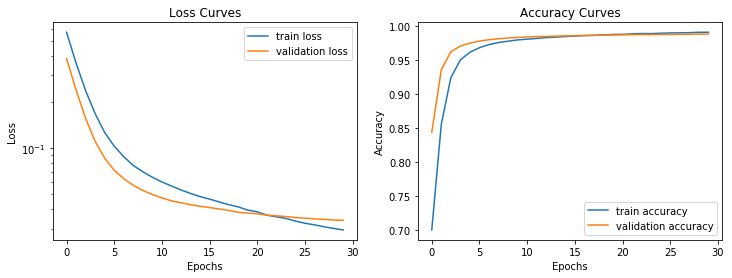

In [186]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=x_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights-improvement-{epoch:02d}-l_{val_loss:.4f}-{loss:.4f}_-ac_{val_acc:.4f}.hdf5"
mc_top = ModelCheckpoint(filepath,
                         monitor='val_loss', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)


history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30,
                    batch_size=2000, callbacks=[mc_top, plot_losses], verbose=1)

In [150]:
preds = model.predict(x_val)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

result = preds.reshape(-1) == y_val.reshape(-1)
acc_on_test = sum(result)/len(result)
print("Accuracy", acc_on_test)

Accuracy 0.9870214752567694


In [174]:
for weights in glob.glob('*weights-improvement*.hdf5'):
    print(weights)
    model.load_weights(weights)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    scores = model.evaluate(x_val, y_val, verbose=0)
    y_pred = model.predict(x_val)
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    f1_value = f1_score(y_val, y_pred, average='samples')
    print("Scores:", scores, "F1:", f1_value)
    print("-\n")
    

weights-improvement-29-l_0.0343-0.0294_-ac_0.9881.hdf5
Scores: [0.03425131075912052, 0.988062554314023] F1: 0.9836133783869803
-

weights-improvement-08-l_0.0561-0.0741_-ac_0.9815.hdf5
Scores: [0.05611939475176826, 0.981512603305635] F1: 0.9747929884627349
-

weights-improvement-26-l_0.0354-0.0322_-ac_0.9872.hdf5
Scores: [0.03541916524843564, 0.9872455674504477] F1: 0.9825387697438546
-

weights-improvement-22-l_0.0369-0.0364_-ac_0.9867.hdf5
Scores: [0.036873842527468996, 0.9867366989453633] F1: 0.9818957273744036
-

weights-improvement-06-l_0.0690-0.0975_-ac_0.9782.hdf5
Scores: [0.06898172135863985, 0.9782166132851252] F1: 0.9700782611674965
-

weights-improvement-20-l_0.0377-0.0390_-ac_0.9864.hdf5
Scores: [0.03765332828911524, 0.98642856980127] F1: 0.9814505760157989
-

weights-improvement-03-l_0.1477-0.2268_-ac_0.9645.hdf5
Scores: [0.14766705859275092, 0.9645238060799856] F1: 0.9502995318128865
-

weights-improvement-09-l_0.0524-0.0674_-ac_0.9820.hdf5
Scores: [0.05240171298621193, 0

### Test images from Hacker Earth

In [158]:
bottles = glob.glob(DATA_DIR + "/test_img/*.txt")
x, y = features_from_bottles(bottles)

In [179]:
top =  "weights-improvement-29-l_0.0343-0.0294_-ac_0.9881.hdf5"
bottom = "weights-improvement-21-l_0.0373-0.0375_-ac_0.9870.hdf5"

model.load_weights(bottom)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [180]:
preds = model.predict(x)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [181]:
attribs = ['attrib_'+"{:02}".format(i) for i in range(1, 86)]

data = {}
for i in range(len(preds)):
    row = {a: int(b)  for (a,b) in zip(attribs, preds[i])}
    data[y[i]] = row
    
result = []
for val in test_labels.index:
    point_ = data[val]
    point_['Image_name'] = val
    result.append(point_)

df_preds = pd.DataFrame(result)
df_preds = df_preds.set_index('Image_name')
df_preds.to_csv('result.csv')

In [182]:
print(df_preds.shape)
df_preds.head()

(5400, 85)


,attrib_01,attrib_02,attrib_03,attrib_04,attrib_05,attrib_06,attrib_07,attrib_08,attrib_09,attrib_10,...,attrib_76,attrib_77,attrib_78,attrib_79,attrib_80,attrib_81,attrib_82,attrib_83,attrib_84,attrib_85
Image_name,,,,,,,,,,,,,,,,,,,,,
Image-1.jpg,0,0,0,0,0,1,0,0,1,1,...,0,0,0,1,1,0,0,1,0,1
Image-2.jpg,0,1,0,0,0,1,1,0,0,0,...,0,1,0,1,1,0,0,0,1,1
Image-3.jpg,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
Image-4.jpg,1,0,0,0,1,1,1,0,0,1,...,0,1,1,1,0,0,0,0,0,1
Image-5.jpg,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
